# 0.0 Imports

In [2]:
import sweetviz 

import math
import inflection
import pickle
import random
import warnings
import requests
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.gridspec as gridspec
import xgboost             as xgb

import json

from scipy      import stats  as ss
from matplotlib import pyplot as plt

from tabulate              import tabulate
from IPython.core.display  import HTML
from IPython.display       import Image

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from sklearn.metrics       import mean_absolute_error, mean_squared_error #mean_absolute_percentage_error,
from sklearn.linear_model  import LinearRegression, Lasso

import datetime

warnings.filterwarnings ("ignore") 

pd.__version__


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/raquelrocha/opt/anaconda3/envs/env_ds/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


'1.4.1'

## 0.1 Helper Functions

In [3]:
def cross_validation(X_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print("\nKFold Number:{}".format(k))

        # start and end date for validation
        validation_start_date = X_training["date"].max() - datetime.timedelta(days=k*6*7) # ao alterar o número 1 e 0 abaixo, vai mudando o tempo do k=1 k=2 k=3 etapas d ciclo do cross validation, p.s. colocamos a função usando o k no lugar do número
        validation_end_date = X_training["date"].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = X_training[X_training["date"] < validation_start_date]
        validation = X_training[(X_training["date"] >= validation_start_date) & (X_training["date"] <= validation_end_date)]

        # training and validation dataset
        # Training
        Xtraining = training.drop(["date", "sales"], axis=1)
        Ytraining = training["sales"]

        # Validation
        Xvalidation = validation.drop(["date", "sales"], axis=1)
        Yvalidation = validation["sales"]

        # model
        m = model.fit(Xtraining, Ytraining)
        
        # prediction
        yhat = m.predict(Xvalidation)                        
        
        # performance   
        m_result = ml_error(model_name, np.expm1(Yvalidation), np.expm1(yhat))

        # Store performance of each kfold iteration
        mae_list.append(m_result["MAE"])
        mape_list.append(m_result["MAPE"])
        rmse_list.append(m_result["RMSE"])

    return pd.DataFrame ({"Model Name": model_name,
                      "MAE CV": np.round(np.mean(mae_list),2).astype(str)+ ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                      "MAPE CV": np.round(np.mean(mape_list),2).astype(str)+ ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                      "RMSE CV": np.round(np.mean(rmse_list),2).astype(str)+ ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index =[0])


def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs(y - yhat) / y)


def ml_error (model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({"Model Name": model_name,
                        "MAE": mae,
                        "MAPE": mape,
                        "RMSE":rmse}, index=[0])


def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )  

def cramers_v_df(categorical_features):

    rows= []

    for var1 in categorical_features:

        col = []

        for var2 in categorical_features:
            cramers =cramer_v(categorical_features[var1], categorical_features[var2]) 
            col.append(round(cramers,3)) 

        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=categorical_features.columns, index=categorical_features.columns)

    return df

def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

sns.set()
  

In [4]:
jupyter_settings()

## 0.2 Loading Data

In [5]:
df_test_raw= pd.read_csv("/Users/raquelrocha/documents/ProjetosComunidadeDS/DSProducao/data_mercari/test_stg2.tsv", sep = '\t')
df_train_raw= pd.read_csv("/Users/raquelrocha/documents/ProjetosComunidadeDS/DSProducao/data_mercari/train.tsv", sep = '\t')


In [6]:
df_test_raw.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [7]:
df_train_raw.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
df_train_raw.tail()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...
1482534,1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,NaN,22.0,0,"New with tag, red with sparkle. Firm price, no..."


# 1.0 Descrição dos Dados

In [6]:
df1 = df_train_raw.copy()

## 1.2 Data Dimensions

In [10]:
print ("Number of Rows:{}".format(df1.shape[0]))
print ("Number of Cols:{}".format(df1.shape[1]))

Number of Rows:1482535
Number of Cols:8


## 1.3 Data Types

In [11]:
df1.dtypes


train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

## 1.5 Fillout NA (Substituindo os dados faltantes)

In [13]:
df1.sample()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1310307,1310307,FREE SHIP Hollister Medium Tee,3,Women/Tops & Blouses/T-Shirts,Hollister,5.0,1,"Worn a few times, great condition."


In [14]:
#category_name
df1["category_name"].fillna(value= "sem descrição", inplace=True)

#brand_name
df1["brand_name"].fillna(value= "sem marca", inplace=True)

#item_description
df1["item_description"].fillna(value= "sem descrição", inplace=True)


In [15]:
df1.isna().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

## 1.6 Change Types (Estatística Descritiva)


## 1.7 Descriptive Statistical 

In [16]:
#numérico
num_attributes = df1.select_dtypes(include=["int64", "float64"])
#categórico
cat_attributes = df1.select_dtypes(exclude=["int64", "float64","datetime64[ns]"])

In [17]:
num_attributes.sample(5)

,train_id,item_condition_id,price,shipping
860923,860923,3,19.0,0
174342,174342,1,18.0,1
1343139,1343139,2,94.0,0
1238509,1238509,1,16.0,0
504521,504521,1,50.0,1


In [18]:
cat_attributes.sample(5)

,name,category_name,brand_name,item_description
320886,RAE DUNN MAGENTA DISCOVER CRAB CANISTER,Home/Kitchen & Dining/Coffee & Tea Accessories,Rae Dunn,No description yet
994880,Ray-Ban glasses,Women/Women's Accessories/Sunglasses,Ray-Ban,My prescription is in them but can be replaced...
339367,20 instant breast bare lift,Beauty/Tools & Accessories/Other,sem marca,20 pcs /Pack (10 pairs) No bra necessary New I...
173693,Greg peak sport top bundle,Women/Athletic Apparel/Shirts & Tops,Nike,New Nike Dri-Fit Nike Running Size x large Whi...
418136,Velvet Choker,Women/Jewelry/Necklaces,sem marca,2016 2pcs Vintage Retro Black Velvet Choker Ne...


### 1.7.1 Numerical Attributes 

In [25]:
# Central Tendency - Mean Median

# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtsosis

# Desvio padrão
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
# mínimo
d2 = pd.DataFrame(num_attributes.apply(min)).T
# máximo
d3 = pd.DataFrame(num_attributes.apply(max)).T

# Range
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
# Skew
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
# Kurtosis
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
# shapiro
#d7 = pd.DataFrame(num_attributes.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
# name of columns
m.columns = (["attributes", "min", " max", "range","mean" ,"median" ,"std" ,"skew" ,"kurtosis"])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,train_id,0.0,1482534.0,1482534.0,741267.000000,741267.0,427970.990666,-3.388148e-15,-1.200000
1,item_condition_id,1.0,5.0,4.0,1.907380,2.0,0.903158,4.109817e-01,-1.092946
2,price,0.0,2009.0,2009.0,26.737516,17.0,38.586053,1.139323e+01,283.821669
3,shipping,0.0,1.0,1.0,0.447274,0.0,0.497212,2.120850e-01,-1.955023


<AxesSubplot:xlabel='price', ylabel='Density'>

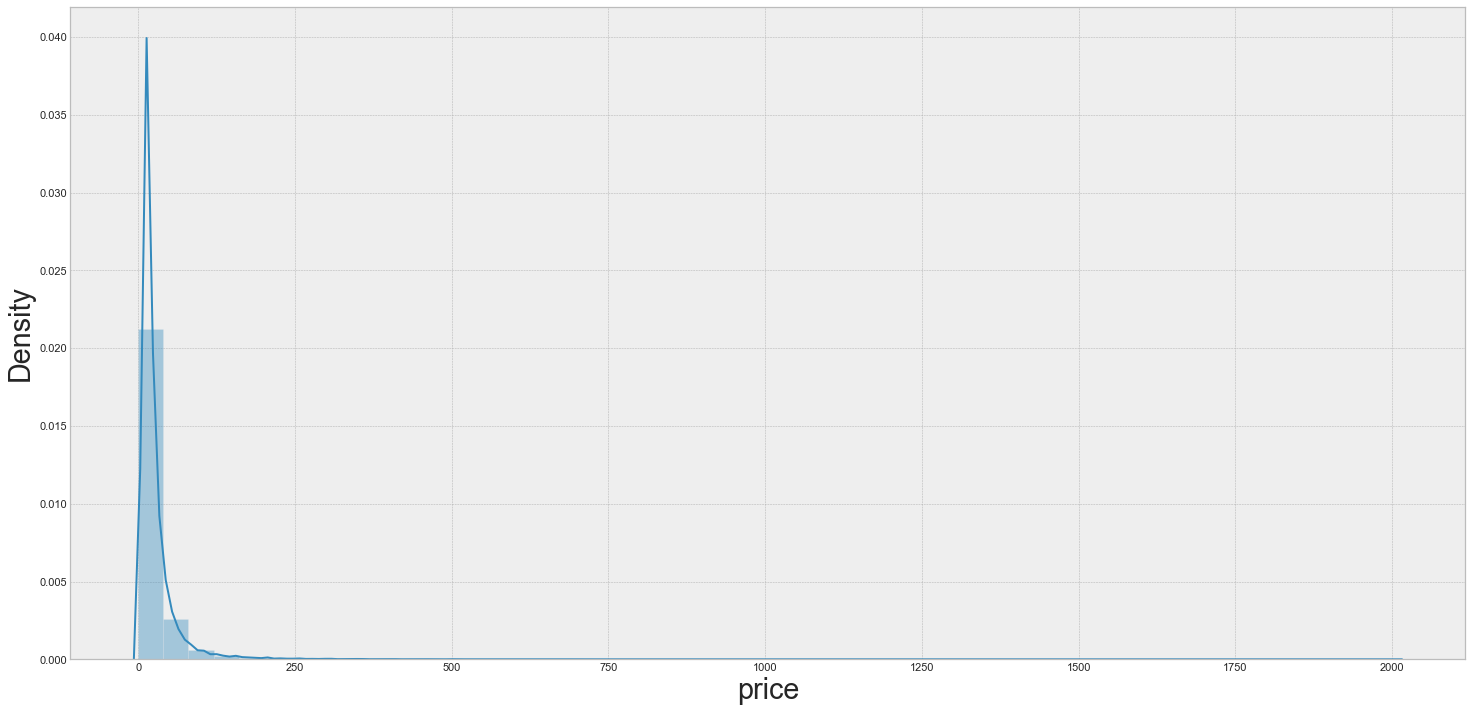

In [26]:
# Exemplo da distribuição do preço
sns.distplot( df1["price"])

### 1.7.2 Categorical Attributes

In [27]:
# níveis que cada variável categórica tem
cat_attributes.apply(lambda x: x.unique().shape[0])

name                1225273
category_name          1288
brand_name             4810
item_description    1281427
dtype: int64

KeyboardInterrupt: 

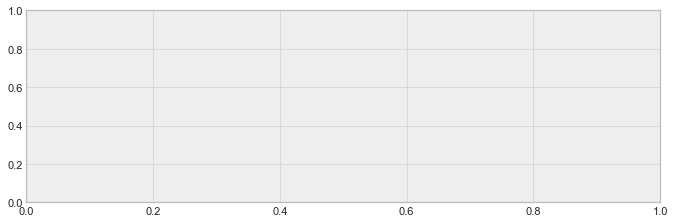

In [28]:
plt.subplot(3, 2, 1)
sns.countplot(df1['name']);

plt.subplot(3, 2, 2)
sns.countplot(df1['category_name']);

plt.subplot(3, 2, 3)
sns.countplot(df1['brand_name']);

plt.subplot(3, 2, 4)
sns.countplot(df1['item_description']);

# 2.0 Feature Engineering
### (criar as variáveis, criar lista de hipóteses e validar as hipóteses)

In [7]:
df2 = df1.copy()

In [ ]:
# category_name (dividir em Masculina, Feminina, Kids, Esportiva, Home)


# 3.0 Filtragem de Variáveis

In [8]:
df3 = df2.copy()

In [30]:
#verificar
df3.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados - EDA
### objetivos da análise exploratória dos dados

In [9]:
df4 = df3.copy()

## SweetViz

In [11]:
df_sweetviz = pd.read_csv("/Users/raquelrocha/documents/ProjetosComunidadeDS/DSProducao/data_mercari/train.tsv", sep = '\t')

In [12]:
relatorio = sweetviz.analyze(df_sweetviz)

                                             |      | [  0%]   00:00 -> (? left)

In [25]:
relatorio.show_html('relatorio.html')

Report relatorio.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 4.1 Análise univariada

### 4.1.1 Responde variable

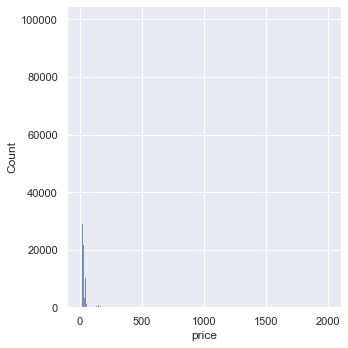

In [42]:
sns.displot(df4["price"])

### 4.1.2 Numerical variable

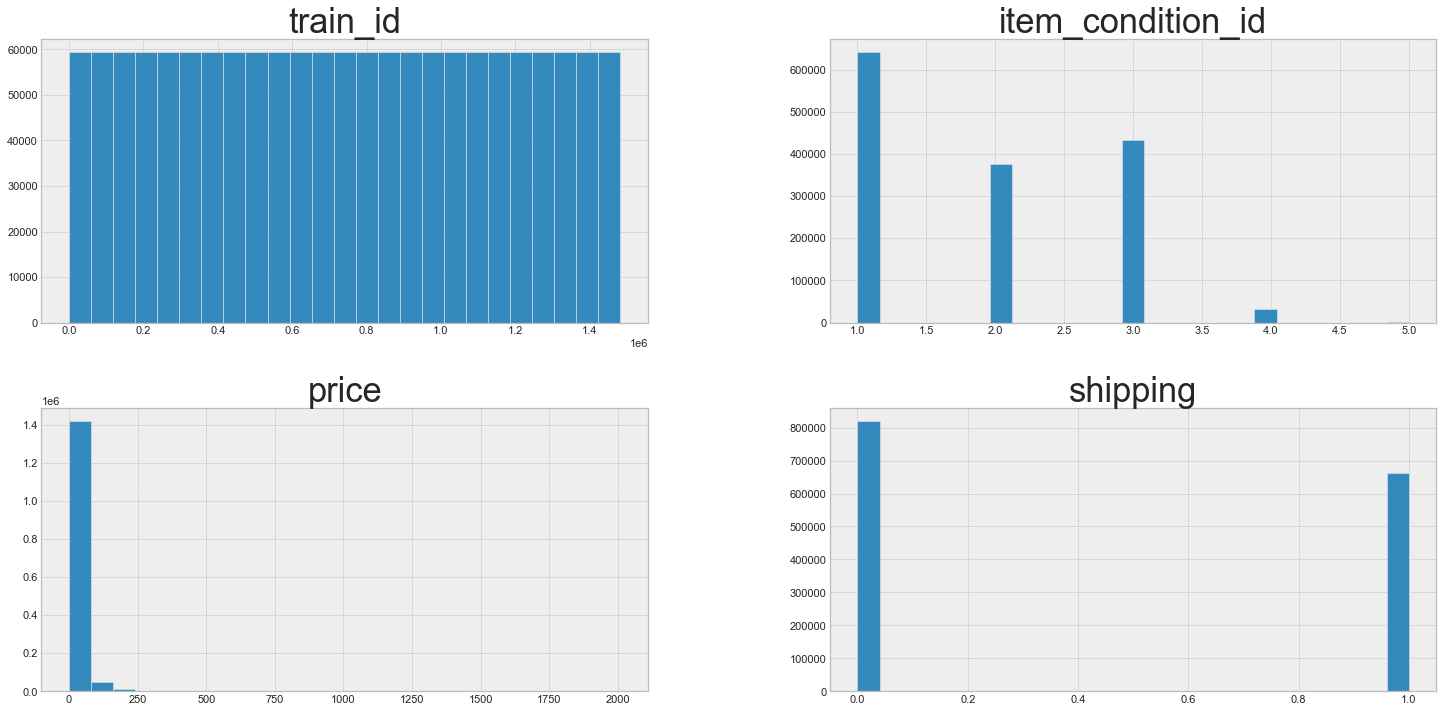

In [34]:
# histograma das variáveis numéricas
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [38]:
cat_attributes.head(10)


,name,category_name,brand_name,item_description
0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,sem marca,No description yet
1,Razer BlackWidow Chroma Keyboard,Electronics/Computers & Tablets/Components & P...,Razer,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,Women/Tops & Blouses/Blouse,Target,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,sem marca,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,Women/Jewelry/Necklaces,sem marca,Complete with certificate of authenticity
5,Bundled items requested for Ruie,Women/Other/Other,sem marca,"Banana republic bottoms, Candies skirt with ma..."
6,Acacia pacific tides santorini top,Women/Swimwear/Two-Piece,Acacia Swimwear,Size small but straps slightly shortened to fi...
7,Girls cheer and tumbling bundle of 7,Sports & Outdoors/Apparel/Girls,Soffe,You get three pairs of Sophie cheer shorts siz...
8,Girls Nike Pro shorts,Sports & Outdoors/Apparel/Girls,Nike,Girls Size small Plus green. Three shorts total.
9,Porcelain clown doll checker pants VTG,Vintage & Collectibles/Collectibles/Doll,sem marca,I realized his pants are on backwards after th...


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

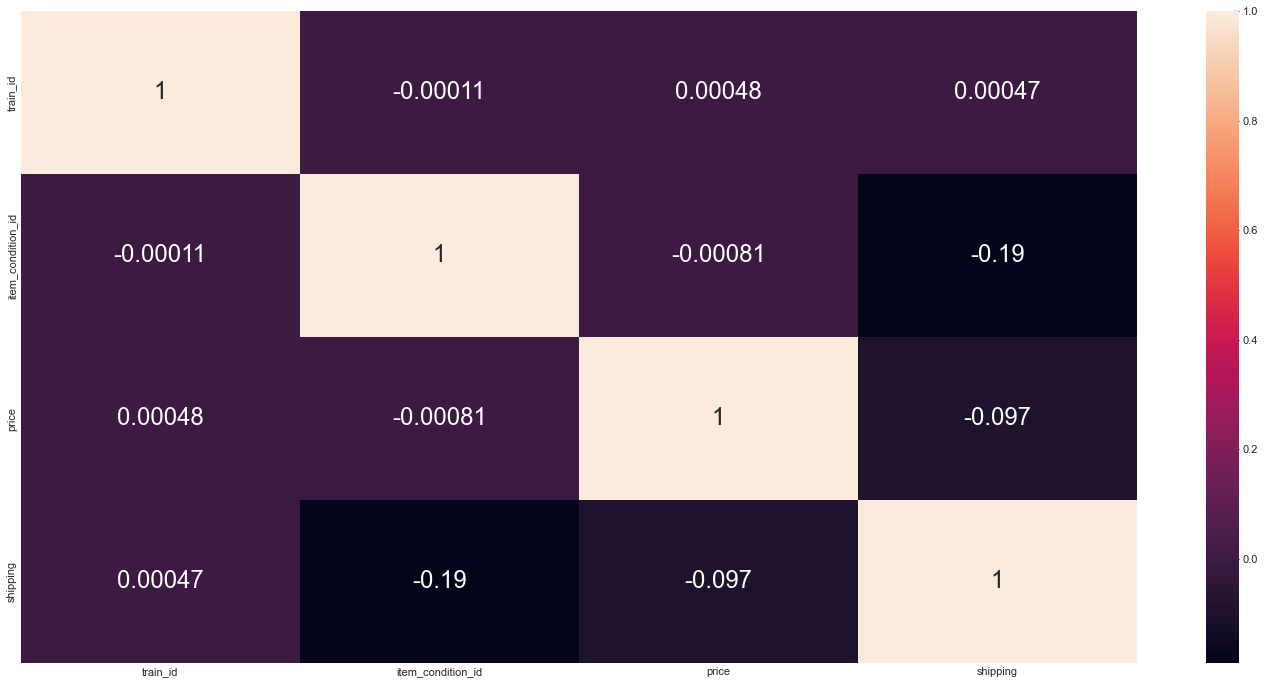

In [42]:
# correlação entre as variáveis
correlation=num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [44]:
cat_attributes.columns

Index(['name', 'category_name', 'brand_name', 'item_description'], dtype='object')

In [53]:
def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )  

def cramers_v_df(categorical_features):

    rows= []

    for var1 in categorical_features:

        col = []

        for var2 in categorical_features:
            cramers =cramer_v(categorical_features[var1], categorical_features[var2]) 
            col.append(round(cramers,3)) 

        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=categorical_features.columns, index=categorical_features.columns)

    return df

In [ ]:
cat_features = cat_attributes

# dataframe with cramer-v 
cramer_v_dataframe = cramers_v_df(cat_features)

# create a mask
mask = np.zeros_like(cramer_v_dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# display heatmap
plt.subplots(figsize=(15, 8))
sns.heatmap( cramer_v_dataframe, annot = True);

#esse abaixo muda o formato do gráfico de correlação
#sns.heatmap( cramer_v_dataframe, annot = True, mask=mask);

# 5.0 Data Preparation

In [44]:
df5 = df4.copy()

In [ ]:
#separando dados para treino e test

X = df4.drop("price", axis=1) #aqui retiro a feature response
y = df4["price"].copy() #aqui adiciono a feature a variável y 

#separando em treino e validação
x_train, x_validation, y_train, y_validation = mms.train_test_split( X, y, test_size=0.20)

#concatenar o x_train e o y_train e colocar em df5
df5 = pd.concat([x_train, y_train], axis=1)


## 5.1 Normalização

In [46]:
#aqui vemos onde colocaremos cada feature nas etapas abaixo
sns.histplot(df5["item_description"]) #aqui é só ir trocando o nome da váriavel


KeyboardInterrupt



Error in callback <function flush_figures at 0x11b331b80> (for post_execute):



KeyboardInterrupt



In [78]:
# Ver quais variáveis irão ser normalizadas, olhando suas distribuções (na analise univariada em numerical variable)
ss = pp.StandardScaler()

df5["item_condition_id"] = ss.fit_transform(df5[["item_condition_id"]].values) # o que está dentro de [[]] me passa um array


## 5.2 Rescaling

In [79]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5["name"] = rs.fit_transform( df5[["name"]].values ) #encontra os parametros da fórmula e aplica nos dados

# competition time month
df5["category_name"] = rs.fit_transform( df5[["category_name"]].values ) #encontra os parametros da fórmula e aplica nos dados

# promo time week
df5["brand_name"] = mms.fit_transform( df5[["brand_name"]].values ) #encontra os parametros da fórmula e aplica nos dados

# year
df5["item_description"] = mms.fit_transform( df5[["item_description"]].values ) #encontra os parametros da fórmula e aplica nos dados


## 5.3 Transformação

### 5.3.1 Encoding

In [ ]:

#driving_license - essa feature já está em 0 e 1 então já está "encodado"

#region_code 
#Label Encoding (mapeia se tem ou não tem Ex: 0 e 1)

#One Hot Encoding (identifica um estado Ex:0 e 1), nesse caso tem 52 (não indicado)
#P.S. quando tem muitos(acima de 6/7) níveis em sua variável categórica, se usar uma hot encoding irá criar muitas dimensões no dataset que a amostra de dimensionalidade irá acabar com o modelo

#aqui podemos usar qualquer um desses, o Meigarom indica o Target Encoding, no prmeiro ciclo 
#Frequency Encoding (conta a frequência, quantas pessoas tem a licença por classe)
#Target Encoding (calcula a média, de quantas pessoas tem a licença e divide pelo total de pessoas daquele grupo)
#Weighted Target Encoding (dar peso manual para a variável Ex: quanto maior o peso mais próximo fica da média, e quanto menor o peso fica mais distante da média)


#previously_insurence - essa feature já está em 0 e 1 então já está "encodado"


#vehicle_age
#Order Encoding (mapeia a ordem ex: 2 anos seria 2x de 1 ano, e 3 anos seria 3x de 1 ano e assim vai)
#One Hot Encoding (identifica um estado Ex: velho e novo)
#Frequency Encoding (conta a frequência, quantos carros que são velhos, quantos carros que são novos)


#vehicle_damage - essa feature já está em 0 e 1 então já está "encodado"


#policy_sales_channel
#Frequency Encoding (conta a frequência, qual tipo de contato o cliente quer ter)
#Target Encoding (calcula a média, de quantas pessoas tem a licença e divide pelo total de pessoas daquele grupo)

#P.S. função Get_dummys (pandas), é igual ao Hot Encoding


In [50]:
df5.tail(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1482525,1482525,Red Victoria's Secret bra w sequins,2,Women/Underwear/Bras,PINK,2.079442,1,Removable straps to make strapless Size: 34 B ...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women/Tops & Blouses/T-Shirts,sem marca,2.564949,0,"Great Harry Potter Shirt! ""Hogwarts, School of..."
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women/Tops & Blouses/Blouse,sem marca,2.397895,1,Brand new black and white ribbed mock neck bod...
1482528,1482528,Victoria's Secret Tankini Sz. Large,2,Women/Athletic Apparel/Sports Bras,Victoria's Secret,2.944439,1,Purple and Paisley Victoria's Secret Tankini S...
1482529,1482529,Men's UA [rm],2,Men/Athletic Apparel/Shirts & Tops,Under Armour,3.555348,0,[rm] for the set both in perfect condition no ...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,3.044522,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,2.708050,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,sem marca,2.564949,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,sem marca,3.828641,1,There is 2 of each one that you see! So 2 red ...
1482534,1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,sem marca,3.135494,0,"New with tag, red with sparkle. Firm price, no..."


In [52]:
df5["brand_name"].unique()

array(['sem marca', 'Razer', 'Target', ..., 'Astroglide',
       'Cumberland Bay', 'Kids Only'], dtype=object)

In [80]:
# variáveis categóricas

# One Hot Encoding
# shipping
df5 = pd.get_dummies( df5, prefix=["shipping"], columns=["shipping"])

# Ordinal Encoding
# item_condition_id
ord1 = OrdinalEncoder()
df5['item_condition_id'] = ord1.fit_transform ( df5["item_condition_id"])

# Label Encoding
# category_name
le = LabelEncoder()
df5["category_name"] = le.fit_transform ( df5["category_name"])

# Target Encoding
# brand_name
te = TargetEncoder()
df5["brand_name"] = te.fit_transform ( df5["brand_name"])


# Frequency Encoding
# item_description
fe = FrequencyEncoder()
df5["item_description"] = fe.fit_transform ( df5["item_description"])


### 5.3.2 Response Variable Transformation

In [47]:
df5["price"] = np.log1p( df5["price"])

# 6.0 Feature Selection
### implementando o Boruta (algoritmo)

In [48]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [84]:
# deletar as variáveis originais

# aqui são as colunas que iremos deletar
cols_drop = [" "]

# recriar dataset sem as colunas que foram retiradas
df6 = df6.drop(cols_drop, axis=1)

## 6.2 Boruta as Feature Selector

In [ ]:
# implementação do Boruta

# training and test dataset for Boruta
x_train_n = x_train.drop(["price"], axis=1).values
y_train_n = y_train.values.ravel()

#definindo Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)

#definindo Boruta
boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(x_train_n, y_train_n)


### 6.2.1 Best Features from Boruta

In [ ]:
# variáveis que o boruta rankeou/selecionou como mais importantes
cols_selected = boruta.support_.tolist()

## best features
x_train_fs = x_train.drop(["price"], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# colunas que o boruta não rankeou/selecionou
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))


## 6.3 Manual Feature Selection

In [84]:
# acrescentar a lista o month_sin e week_of_year_sin
cols_selected_boruta = [
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
     ' ',
         ]

# columns to add
feat_to_add = ["price"]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


# 7.0 Machine Learning Modelling

In [ ]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = x_train[cols_selected_boruta_full]

## 7.2 Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(yhat_lr))
lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(X_training, 5, "Linear Regression", lr, verbose=False)
    

In [ ]:
lr_result_cv

## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso(alpha=0.01).fit(X_train, y_train)
# prediction
yhat_lrr = lrr.predict(X_test)

# performance
lrr_result = ml_error("Linear Regression - Lasso", np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(X_training, 5, "Lasso", lrr, verbose=False)
lrr_result_cv


## 7.4 Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)  

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(X_training, 5, "Random Forest Regressor", rf, verbose=True)
rf_result_cv


## 7.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective="reg:squarederror",
                              n_estimators=100, 
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit(X_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error("XGBoost Regressor", np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1 XBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(X_training, 5, "XGBoost Regressor", model_xgb, verbose=False)
xgb_result_cv


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat([lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values("RMSE")


### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv
